# LTSM Threshold Strategy 

### References
https://www.tensorflow.org/tutorials/structured_data/time_series

https://www.datacamp.com/tutorial/lstm-python-stock-market

https://machinelearningmastery.com/how-to-develop-lstm-models-for-time-series-forecasting/

https://towardsdatascience.com/how-not-to-use-machine-learning-for-time-series-forecasting-avoiding-the-pitfalls-19f9d7adf424



In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import datetime as dt
import numpy as np

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, confusion_matrix

import yfinance as yf
from backtesting import Strategy, Backtest 
from backtesting.lib import crossover

/Users/alexandramcadam/Documents/Uni/Year4/QuantProject/quantenv/lib/python3.9/site-packages/backtesting/_plotting.py:50: UserWarning: Jupyter Notebook detected. Setting Bokeh output to notebook. This may not work in Jupyter clients without JavaScript support (e.g. PyCharm, Spyder IDE). Reset with `backtesting.set_bokeh_output(notebook=False)`.
  warnings.warn('Jupyter Notebook detected. '


Loading BokehJS ...

In [2]:
def get_raw_data(name, start_time="2000-01-01", end_time="2020-01-01"):
    ticker = yf.Ticker(name)
    data = ticker.history(start=start_time, end=end_time)

    plt.figure(figsize = (18,9))
    plt.plot(range(data.shape[0]),data['Close'], color='purple')
    plt.title(name + ' Raw Data')
    plt.xticks(range(0,data.shape[0],500),data.index[::500],rotation=45)
    plt.xlabel('Date')
    plt.ylabel('Close Price')
    plt.show()

    return data 


In [3]:
def process_data(data, factor_window, lookback_window):
    
    # calculate momentum 
    data['Momentum'] = data['Close'].pct_change(periods=factor_window)

    # calculate rolling volatility
    data['Volatility'] = data['Close'].rolling(window=factor_window).std()

    #drop NaN values 
    data = data[factor_window:]

    #choose features 
    feature_data = data[['Close', 'Momentum', 'Volatility']]

    #normalise data 
    scaler = MinMaxScaler()
    feature_data_scaled = scaler.fit_transform(feature_data)

    #split data into training and test sets
    train_size = 0.8  # 80% training, 20% testing
    train_data, test_data = train_test_split(feature_data_scaled, train_size=train_size, shuffle=False)
    
    #input and truth labels
    X_train, y_train = [], []
    
    #convert to numpy 
    train_data_np = train_data #already numpy? 
    
    #create samples for X and target for y
    for i in range(lookback_window, len(train_data_np)):
        # X includes all features from train_data_np 
        X_train.append(train_data_np[i - lookback_window:i])  
        
        # y uses only the 'Close' price as the target value
        y_train.append(train_data_np[i, 0])  
    
    #convert X and y to numpy arrays
    X_train, y_train = np.array(X_train), np.array(y_train)
    
    #reshape X for LSTM input (samples, lookback_window, features)
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], X_train.shape[2]))

    #repeat for test data 
    X_test, y_test = [], []
    
    test_data_np = test_data

    for i in range(lookback_window, len(test_data_np)):
        X_test.append(test_data_np[i - lookback_window:i])  
        y_test.append(test_data_np[i, 0]) 
        
    X_test, y_test = np.array(X_test), np.array(y_test)
    
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], X_test.shape[2]))

    
    return X_train, y_train, X_test, y_test, data, scaler 


In [4]:
def LTSM_model(X, y):
    n_features =  X.shape[2]

    #try to prevent overfitting 
    early_stopping = EarlyStopping(
        monitor='val_loss',  # Metric to monitor (e.g., validation loss)
        patience=3,          # Number of epochs with no improvement after which training will be stopped
        restore_best_weights=True  # Restores model weights from the epoch with the best value of the monitored metric
    )
    
    #split into train and validation data 
    a = int(len(X))
    b = int(a*0.8)
    X_train = X[:b]
    X_valid = X[b:a]
    y_train = y[:b]
    y_valid = y[b:a]
    
    # need to tune hyperparameters and experiemnt with numbers of layers, activation function, lr 
    model = Sequential()
    model.add(LSTM(units=50, return_sequences=True, input_shape=(X.shape[1], n_features)))
    model.add(Dropout(0.2))
    model.add(LSTM(units=50, return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(units=1))
    
    model.compile(optimizer='adam', loss='mean_squared_error') 

    history = model.fit(X_train, y_train, validation_data=(X_valid, y_valid), epochs=20, batch_size=32, callbacks=[early_stopping], verbose=1)                  

    return model 
    

In [5]:
def get_predictions(model, X, y):

    #get predictions 
    predictions = model.predict(X)

    mse = (1/len(predictions))*((np.concatenate(predictions) - y_test**2))
    print(f"MSE: {mse.mean():0.10f} (+/- {mse.std():0.10f})")

    return predictions 


In [6]:
def rescale_data(predictions, data, scaler, lookback_window, y):
    
    #rescale predictions 
    unscaled_predictions = scaler.inverse_transform(np.hstack((predictions, np.zeros((predictions.shape[0], 2)))))[:, 0]
    
    #use all columns 
    unscaled_train_data, unscaled_test_data = train_test_split(data, train_size=0.8, shuffle=False)
    
    unscaled_test_data = unscaled_test_data[lookback_window:] #predictions start after sequence length i.e. 60 or 60+1? might need to shift by 1
    
    unscaled_test_data['Predicted'] = unscaled_predictions #this is scaled need to inverse scale 

    #plot rescaled data 
    plt.figure(figsize = (18,9))
    plt.title('LTSM Model Prediction (Test Data)')
    plt.xticks(range(0,unscaled_test_data.shape[0],100),unscaled_test_data.index[::100],rotation=45)
    plt.plot(range(unscaled_test_data.shape[0]), unscaled_test_data['Close'], label='Close Price', color='purple')
    plt.plot(range(unscaled_test_data.shape[0]), unscaled_test_data['Predicted'], label='Predicted Close Price', color='green')
    plt.xlabel('Date')
    plt.ylabel('Close Price')
    plt.legend()
    plt.show()
    
    return unscaled_test_data

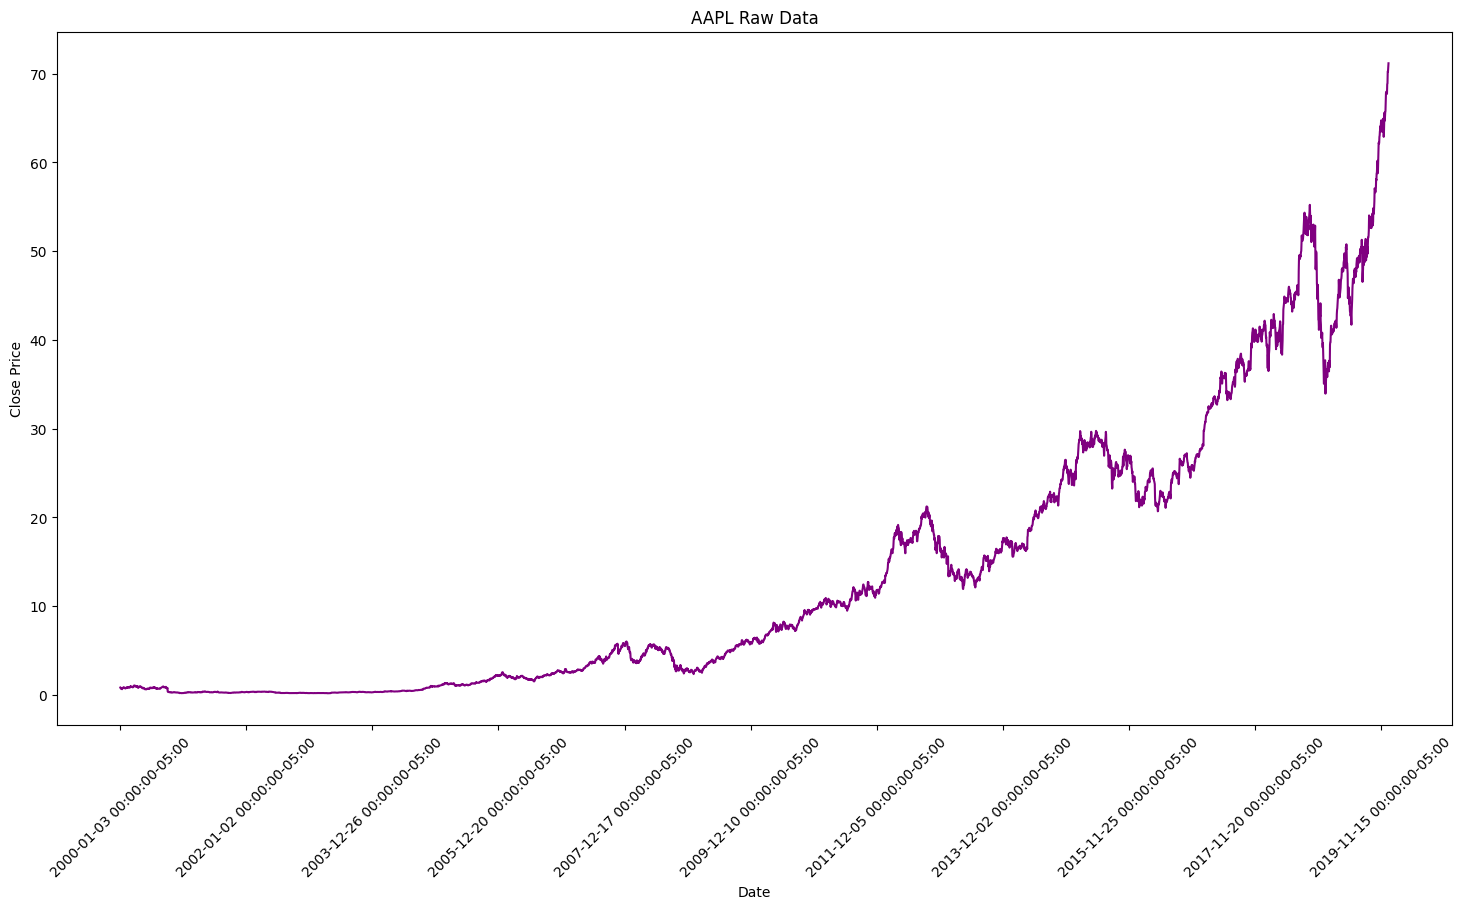

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
MSE: 0.0004470564 (+/- 0.0001408528)


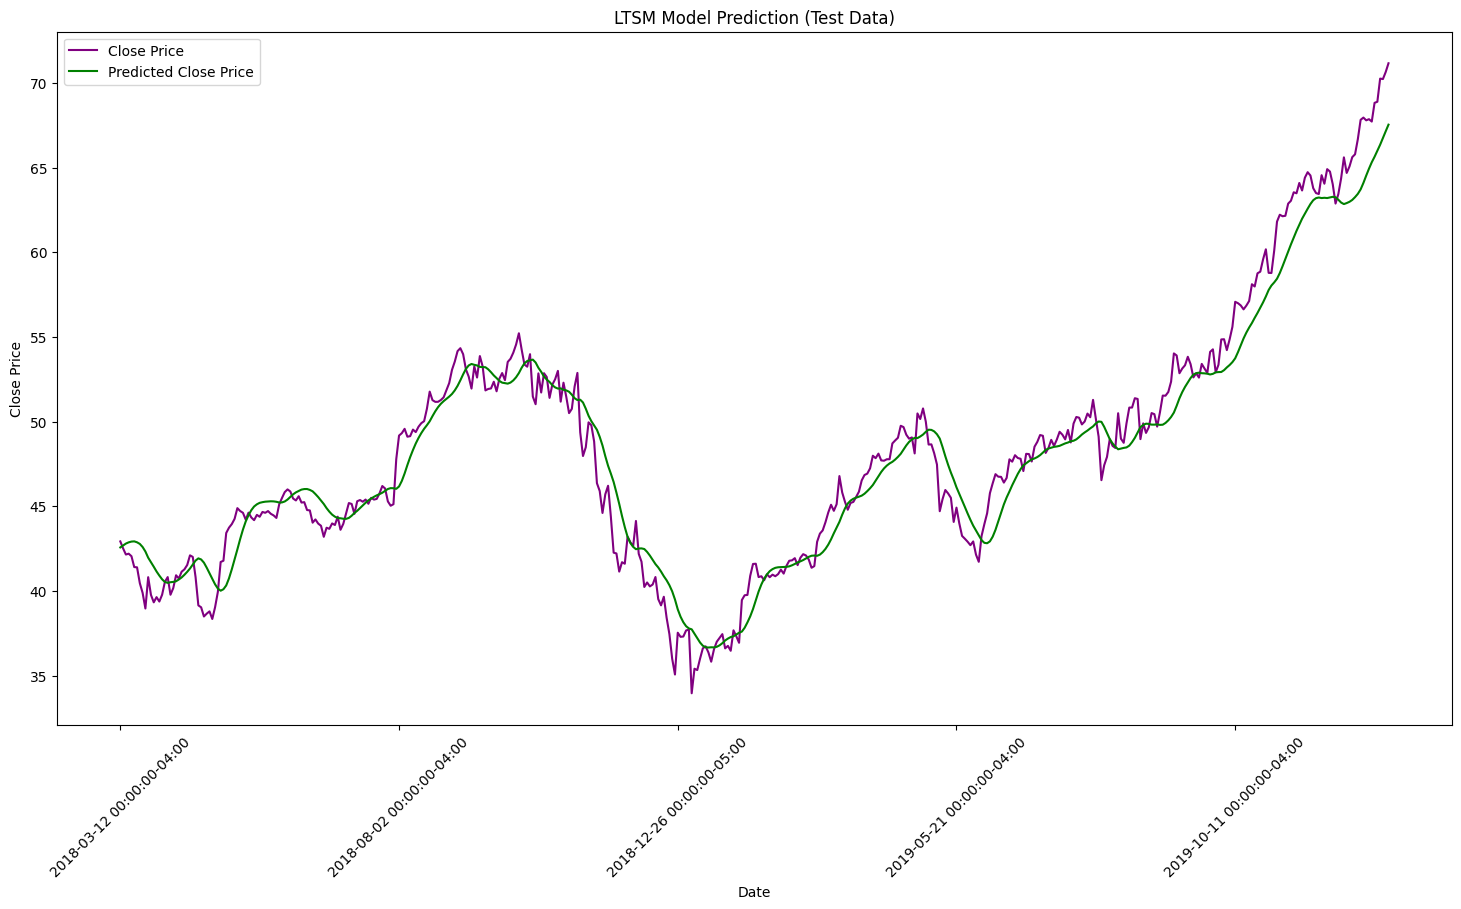

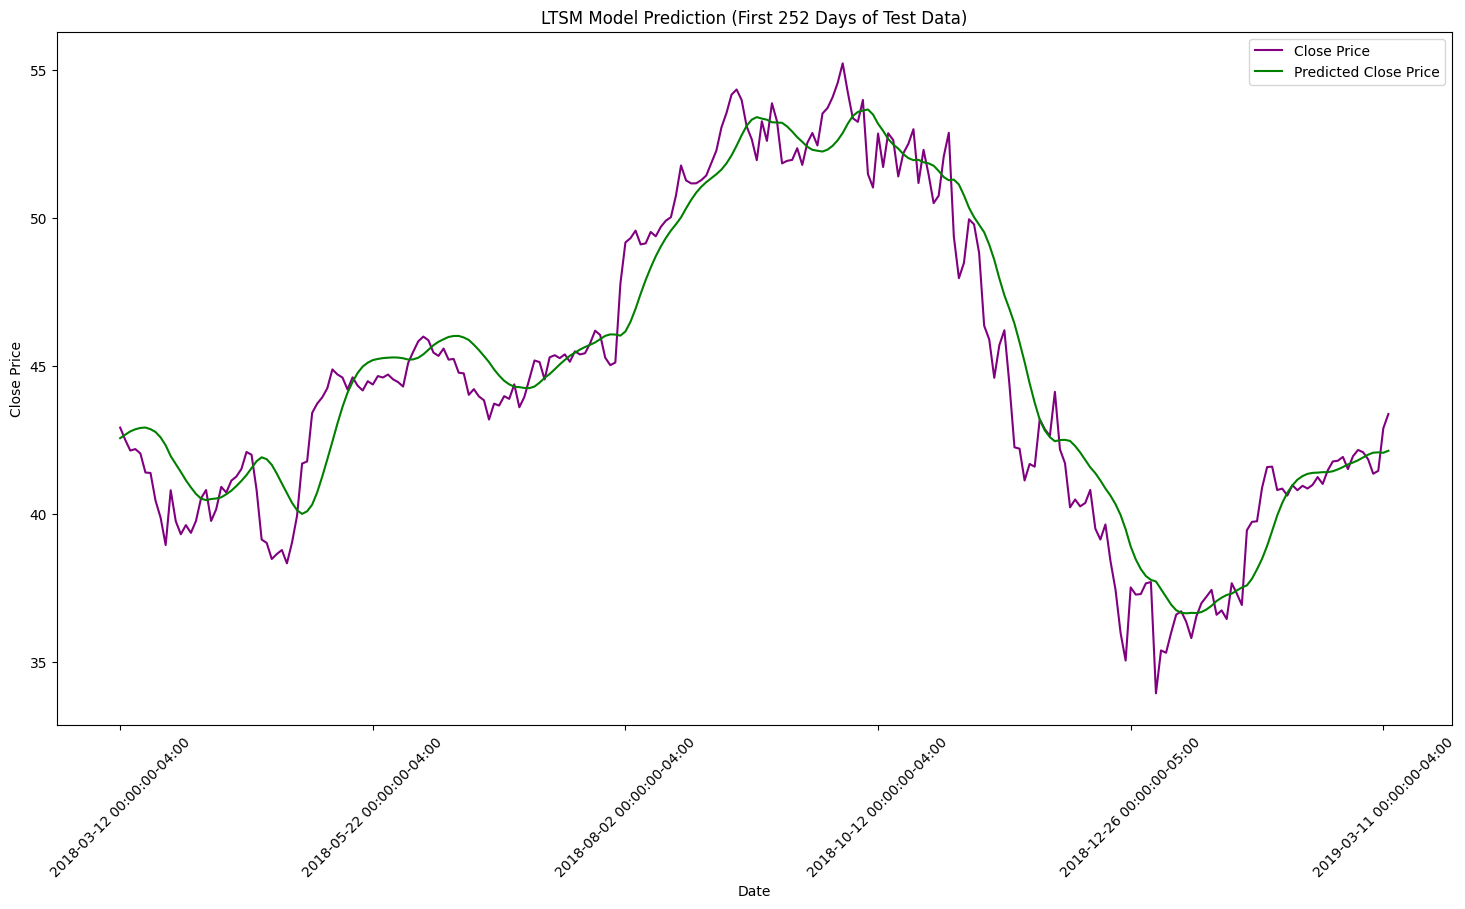

In [17]:
#MAIN 

threshold = 0.05 #optimise 
BUY_THRESHOLD = threshold 
SELL_THRESHOLD = -threshold

class LSTMThresholdStrategy(Strategy):
    BUY_THRESHOLD = threshold 
    SELL_THRESHOLD = -threshold

    def init(self):
        #store predicted price change as an indicator
        self.predicted_change = self.I(self.calculate_predicted_change, name='percentage change')

    def calculate_predicted_change(self):
        #calculate the percentage change between consecutive predicted prices
        
        p_change =  ( self.data['Predicted'] - self.data['Close'] ) / self.data['Close'] 
        
        return p_change

    def next(self):
        #check if the predicted change exceeds the buy threshold
        if self.predicted_change[-1] > BUY_THRESHOLD:
            self.position.close() #what does this do 
            self.buy()
        
        #check if the predicted change is below the sell threshold
        elif self.predicted_change[-1] < SELL_THRESHOLD:
            self.position.close()
            self.sell()


data = get_raw_data("AAPL", start_time="2000-01-01", end_time="2020-01-01") #can change to look at different stocks, start/end optional

factor_window = 252 #optimise #for calculating momentum and volatility 
lookback_window = 252 #optimise #'memory' of the model 
X_train, y_train, X_test, y_test, data, scaler = process_data(data, factor_window, lookback_window) 

#model = LTSM_model(X_train, y_train) #can comment out since no need to retrain every time if data/parameters not changed 
predictions = get_predictions(model, X_test, y_test)
final_data = rescale_data(predictions, data, scaler, lookback_window, y_test)
period = 252 #how long test period  
test_data = final_data[:period]

#plot rescaled data with predictions 
plt.figure(figsize = (18,9))
plt.title(f'LTSM Model Prediction (First {period} Days of Test Data)')
plt.xticks(range(0,test_data.shape[0],50),test_data.index[::50],rotation=45)
plt.plot(range(test_data.shape[0]), test_data['Close'], label='Close Price', color='purple')
plt.plot(range(test_data.shape[0]), test_data['Predicted'], label='Predicted Close Price', color='green')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()

#backtesting - only final 
#bt = Backtest(test_data, LSTMThresholdStrategy, cash=10000, commission=0.001) 

#output = bt.run()
#print(output)

#plot results
#bt.plot()


In [114]:
#save model if works well! 
model_name =  #name of model 
model.save(model_name)

In [126]:
#load models
new_model = tf.keras.models.load_model('model1.keras')

#show the model architecture
new_model.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_14 (LSTM)                  │ (None, 50, 50)         │        10,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 50, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_15 (LSTM)                  │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 93,155 (363.89 KB)

 Trainable params: 31,051 (121.29 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 62,104 (242.60 KB)

29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
MSE: 0.0002391274 (+/- 0.0000711547)


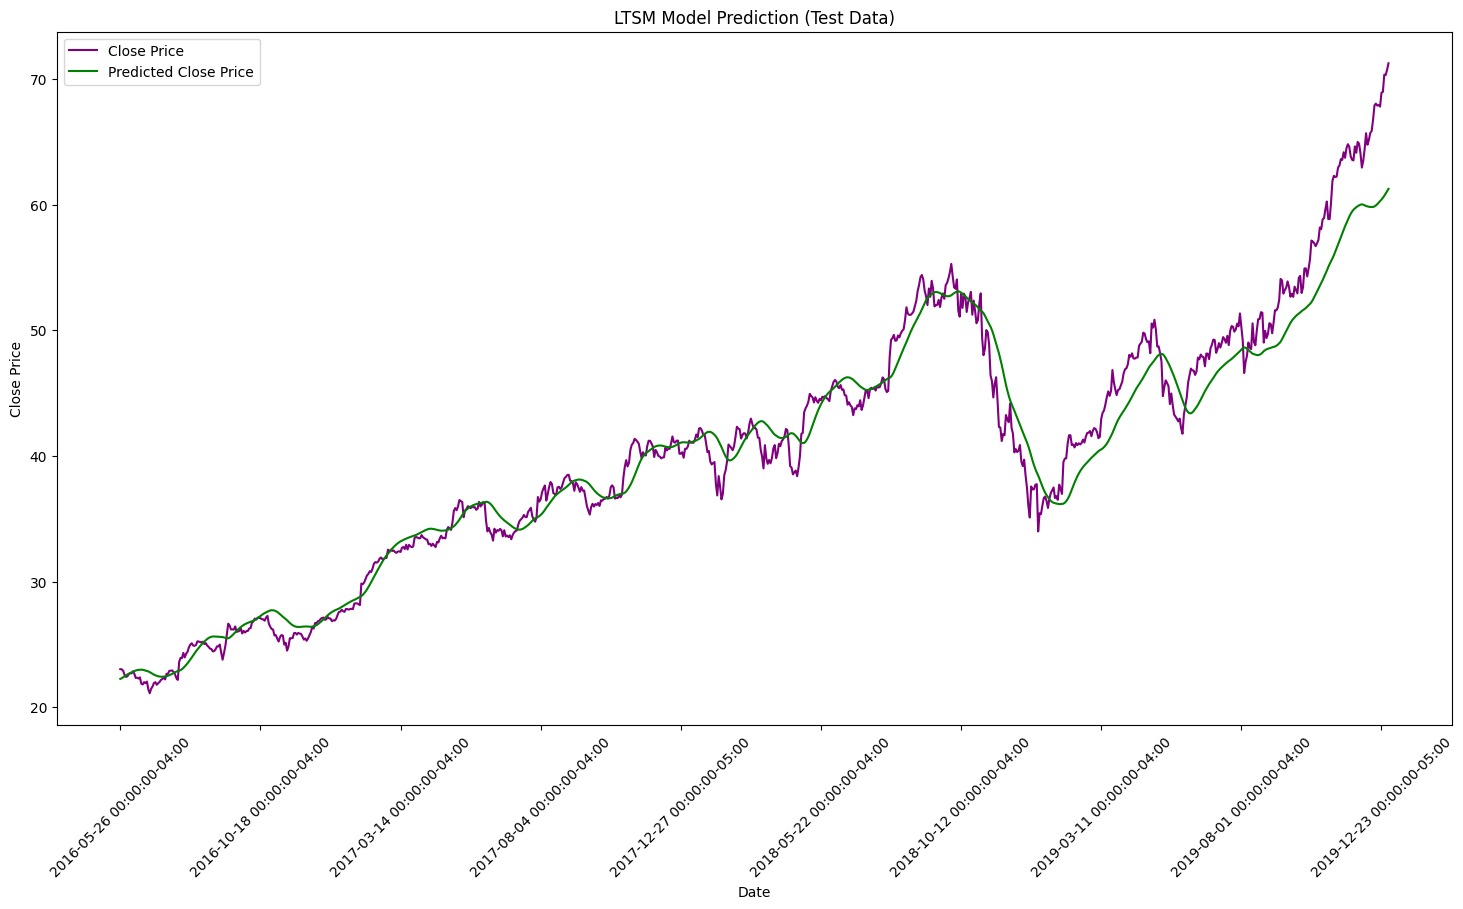

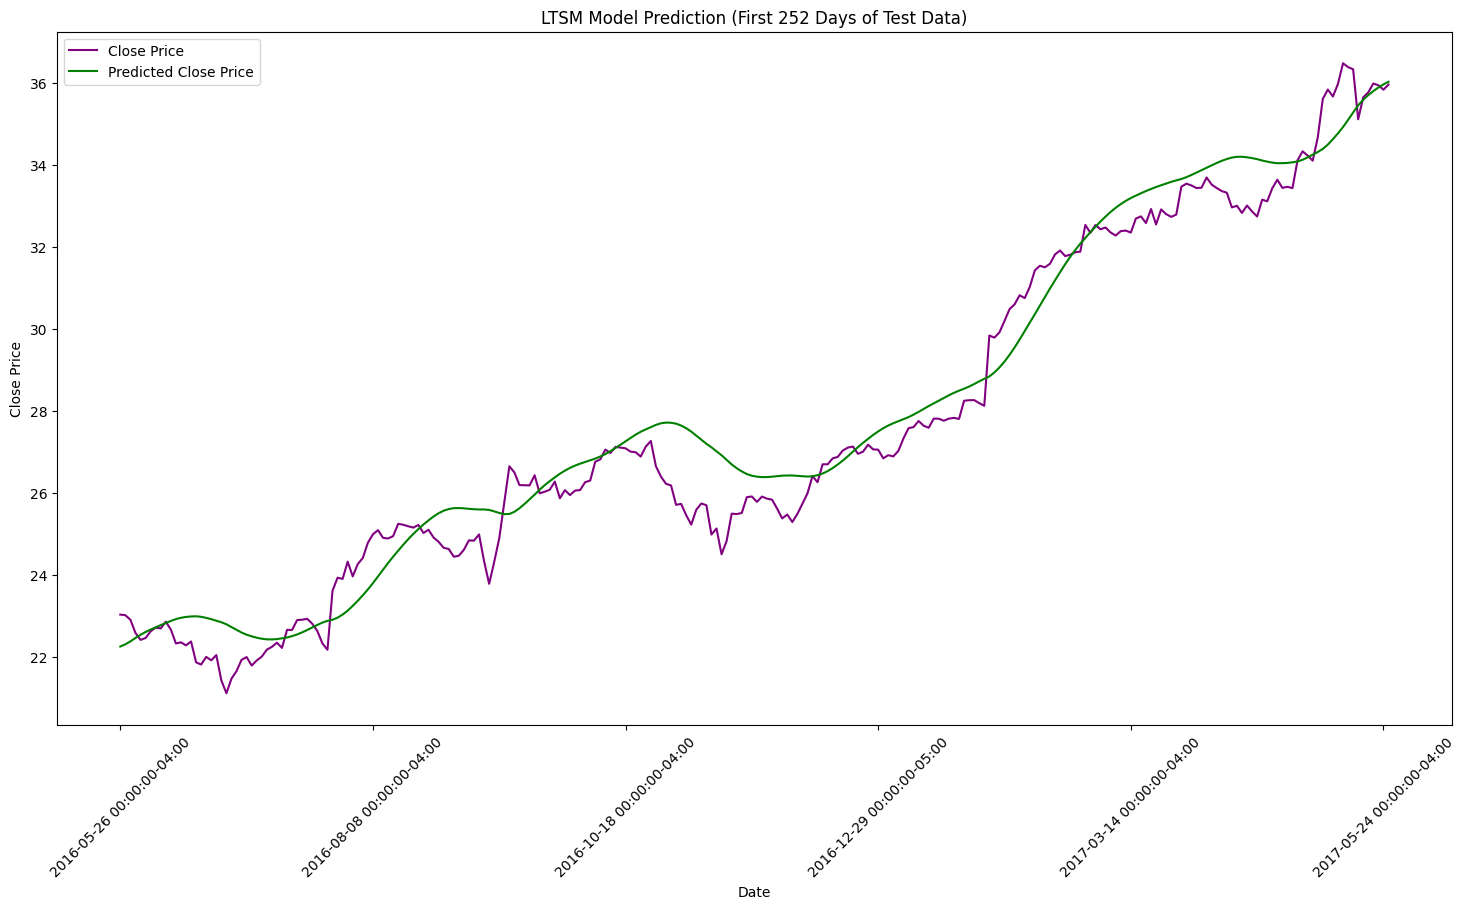

Start                     2016-05-26 00:00...
End                       2017-05-25 00:00...
Duration                    364 days 00:00:00
Exposure Time [%]                   93.650794
Equity Final [$]                 15970.370545
Equity Peak [$]                  16216.341105
Return [%]                          59.703705
Buy & Hold Return [%]               56.176262
Return (Ann.) [%]                   59.703705
Volatility (Ann.) [%]               27.835285
Sharpe Ratio                         2.144893
Sortino Ratio                        6.287361
Calmar Ratio                         5.370265
Max. Drawdown [%]                  -11.117459
Avg. Drawdown [%]                    -1.59079
Max. Drawdown Duration       79 days 00:00:00
Avg. Drawdown Duration       11 days 00:00:00
# Trades                                   21
Win Rate [%]                        52.380952
Best Trade [%]                      45.153621
Worst Trade [%]                     -3.670012
Avg. Trade [%]                    

/Users/alexandramcadam/Documents/Uni/Year4/QuantProject/quantenv/lib/python3.9/site-packages/backtesting/_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%d %b'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],
/Users/alexandramcadam/Documents/Uni/Year4/QuantProject/quantenv/lib/python3.9/site-packages/backtesting/_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%m/%Y'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],
/Users/alexandramcadam/Documents/Uni/Year4/QuantProject/quantenv/lib/python3.9/site-packages/backtesting/_plotting.py:455: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df2 = (df.assign(_width=1).set_index('datetime')
/Users/alexandramcadam/Documents/Uni/Year4/QuantProject/quantenv/lib/python3.9/site-packages/backtesting/_plotting.py:659: UserWarning: found multiple co

GridPlot(id='p15476', ...)

In [127]:
predictions = get_predictions(new_model, X_test, y_test)

mse = (1/len(predictions))*((np.concatenate(predictions) - y_test**2))
print(f"MSE: {mse.mean():0.10f} (+/- {mse.std():0.10f})")

final_data = rescale_data(predictions, data, scaler, lookback_window, y_test)
period = 252 #how long test period  
test_data = final_data[:period]

#plot rescaled data with predictions 
plt.figure(figsize = (18,9))
plt.title(f'LTSM Model Prediction (First {period} Days of Test Data)')
plt.xticks(range(0,test_data.shape[0],50),test_data.index[::50],rotation=45)
plt.plot(range(test_data.shape[0]), test_data['Close'], label='Close Price', color='purple')
plt.plot(range(test_data.shape[0]), test_data['Predicted'], label='Predicted Close Price', color='green')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()

#backtesting 
bt = Backtest(final_data[:time], LSTMThresholdStrategy, cash=10000, commission=0.001) 

output = bt.run()
print(output)

#plot results
bt.plot()

### Optimise Parameters


### Final Test 

Test on unseen data with parameters found through optimisation

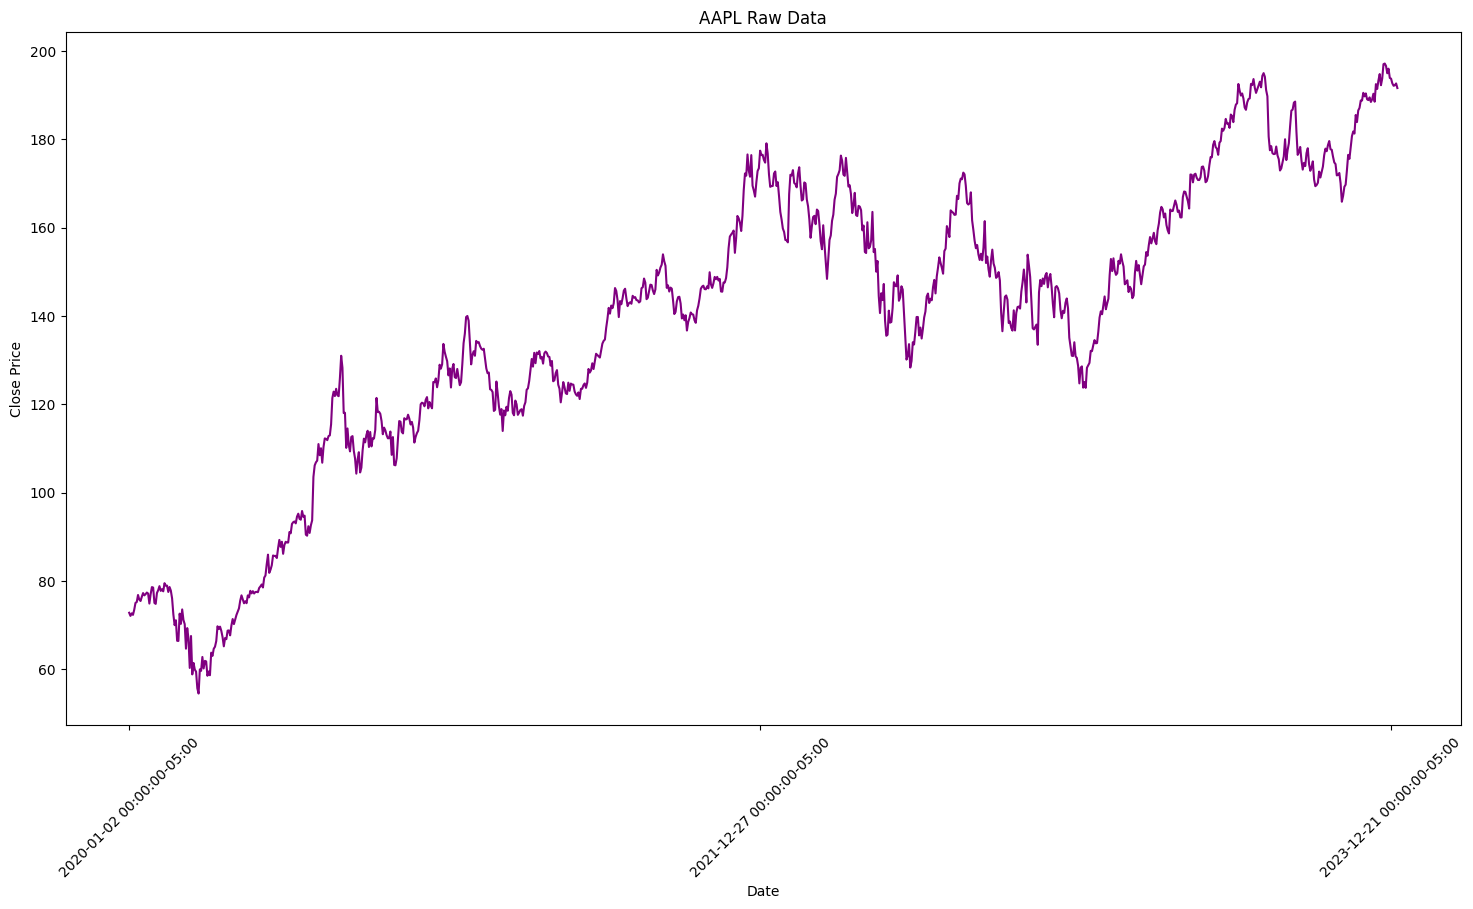

Epoch 1/20


/Users/alexandramcadam/Documents/Uni/Year4/QuantProject/quantenv/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.1342 - val_loss: 0.0148
Epoch 2/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0129 - val_loss: 0.0065
Epoch 3/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0085 - val_loss: 0.0059
Epoch 4/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0079 - val_loss: 0.0052
Epoch 5/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0064 - val_loss: 0.0047
Epoch 6/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0070 - val_loss: 0.0051
Epoch 7/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0071 - val_loss: 0.0044
Epoch 8/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0078 - val_loss: 0.0043
Epoch 9/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0065 - val_loss: 0.0045
Epoch 10/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0065 - val_loss: 0.0038
Epoch 11/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0067 - val_loss: 0.0035
Epoch 12/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0067 - val_l

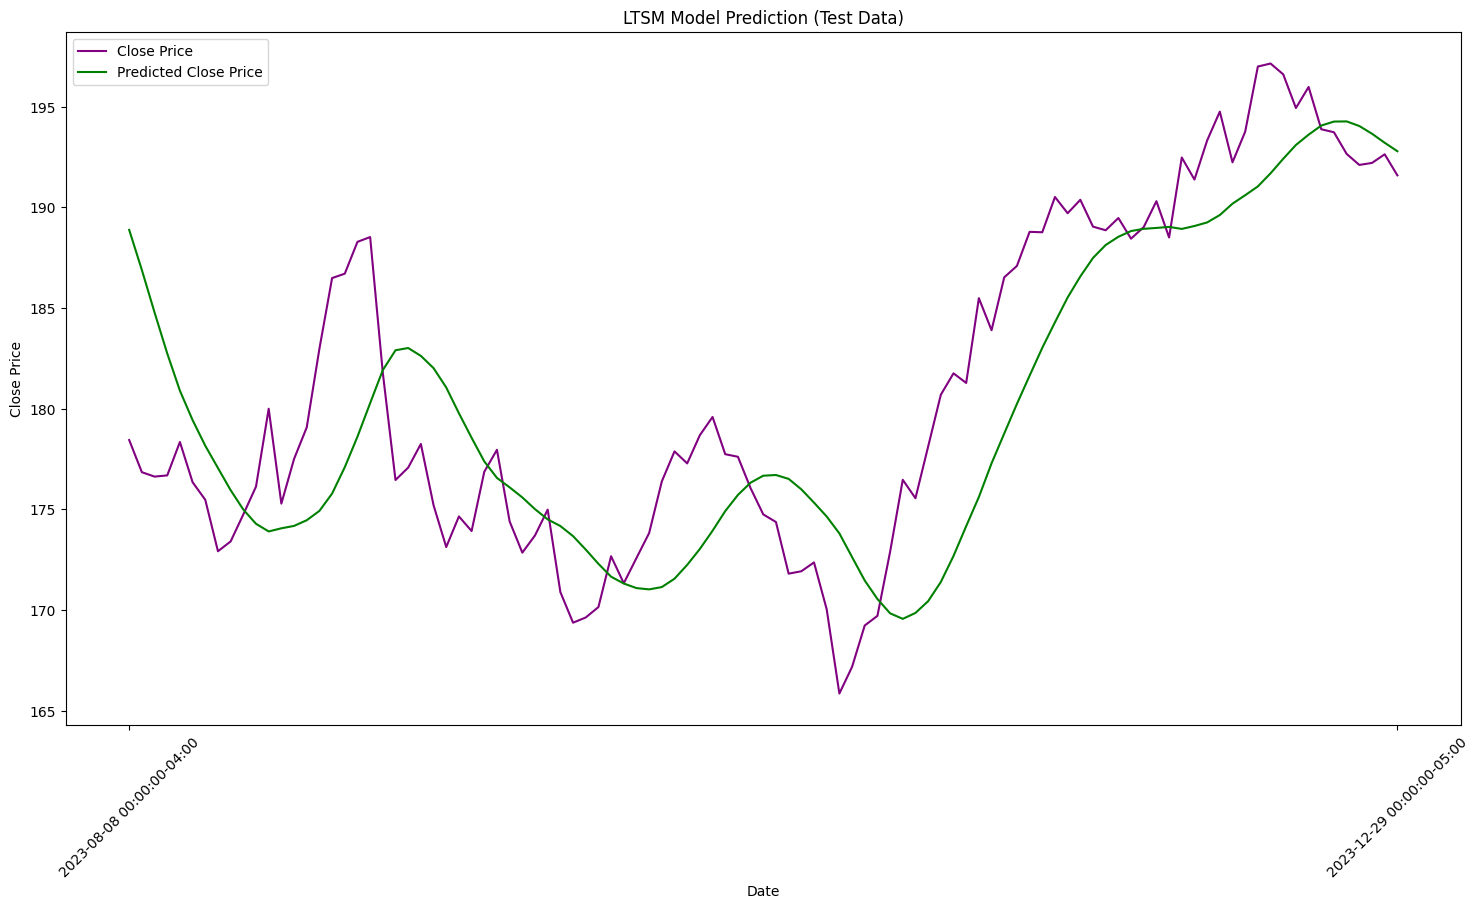

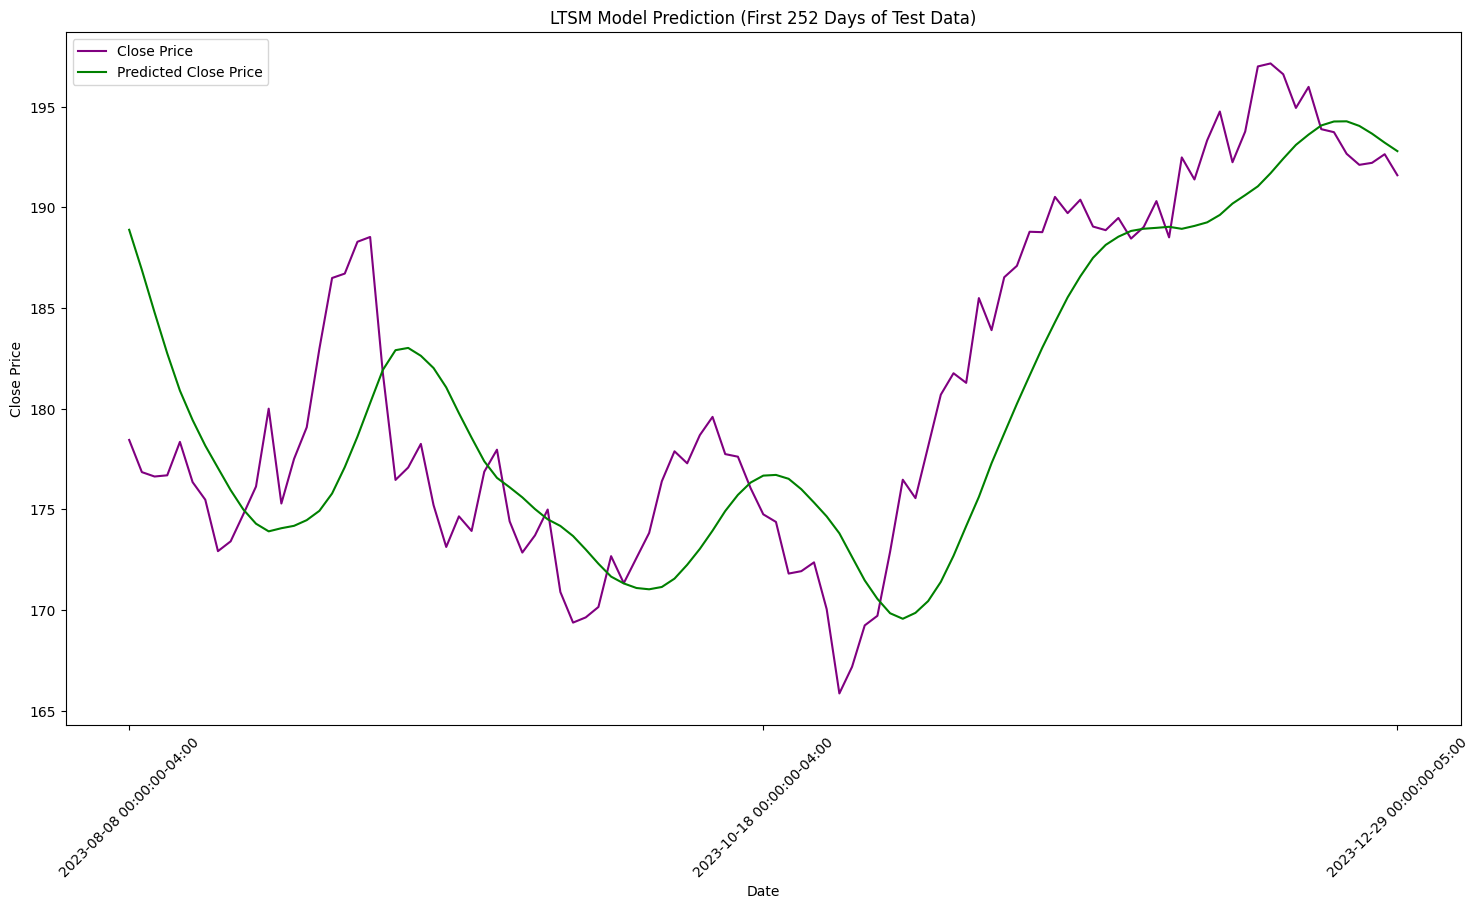

Start                     2023-08-08 00:00...
End                       2023-12-29 00:00...
Duration                    143 days 01:00:00
Exposure Time [%]                   98.019802
Equity Final [$]                 10046.960033
Equity Peak [$]                  11581.139488
Return [%]                             0.4696
Buy & Hold Return [%]                7.365948
Return (Ann.) [%]                    1.175792
Volatility (Ann.) [%]               17.876285
Sharpe Ratio                         0.065774
Sortino Ratio                        0.101764
Calmar Ratio                         0.076985
Max. Drawdown [%]                  -15.273032
Avg. Drawdown [%]                   -3.589085
Max. Drawdown Duration       65 days 00:00:00
Avg. Drawdown Duration       16 days 00:00:00
# Trades                                    6
Win Rate [%]                             50.0
Best Trade [%]                       4.694525
Worst Trade [%]                     -4.452737
Avg. Trade [%]                    

/Users/alexandramcadam/Documents/Uni/Year4/QuantProject/quantenv/lib/python3.9/site-packages/backtesting/_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%d %b'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],
/Users/alexandramcadam/Documents/Uni/Year4/QuantProject/quantenv/lib/python3.9/site-packages/backtesting/_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%m/%Y'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],
/Users/alexandramcadam/Documents/Uni/Year4/QuantProject/quantenv/lib/python3.9/site-packages/backtesting/_plotting.py:455: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df2 = (df.assign(_width=1).set_index('datetime')
/Users/alexandramcadam/Documents/Uni/Year4/QuantProject/quantenv/lib/python3.9/site-packages/backtesting/_plotting.py:659: UserWarning: found multiple co

GridPlot(id='p2903', ...)

In [14]:
data = get_raw_data("AAPL", start_time="2020-01-01", end_time="2024-01-01") #newer data, today is 2023-01-01 use past 3 years for training 


X_train, y_train, X_test, y_test, data, scaler = process_data(data, factor_window, lookback_window) 

model = LTSM_model(X_train, y_train)
predictions = get_predictions(model, X_test, y_test)
final_data = rescale_data(predictions, data, scaler, lookback_window, y_test)
period = 252 #how long test period  
test_data = final_data[:period]

#plot rescaled data with predictions 
plt.figure(figsize = (18,9))
plt.title(f'LTSM Model Prediction (First {period} Days of Test Data)')
plt.xticks(range(0,test_data.shape[0],50),test_data.index[::50],rotation=45)
plt.plot(range(test_data.shape[0]), test_data['Close'], label='Close Price', color='purple')
plt.plot(range(test_data.shape[0]), test_data['Predicted'], label='Predicted Close Price', color='green')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()

#backtesting 
bt = Backtest(final_data, LSTMThresholdStrategy, cash=10000, commission=0.001) 

output = bt.run()
print(output)

#plot results
bt.plot()
